# A/B-тестирование

## Описание проекта

Заказчик провел тестирование изменений, связанных с внедрением улучшенной рекомендательной системы. 

Ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%.

**Цели исследования:** оценить корректность проведения теста, проанализировать его результаты и выявить, было ли улучшение метрик.

## Обзор данных

### Импорт библиотек и данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math as mth
import warnings

from datetime import date, datetime, timedelta
from matplotlib import pyplot as plt

from scipy import stats as st
from plotly import graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


pd.set_option('display.float_format', '{:.2f}'.format)
%config InlineBackend.figure_format = 'retina'
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
marketing = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv') 
participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')

### Обзор датасета marketing 

Календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.


In [3]:
# просмотр датасета с маркетинговыми событиями 
marketing.info()
marketing.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [4]:
# проверка на дубликаты и пропущенные значения
print('Полные дубликаты: {}\n'.format(marketing.duplicated().sum()))
print('Пропущенные значения:\n{}\n'.format(marketing.isna().sum()))

Полные дубликаты: 0

Пропущенные значения:
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64



In [5]:
# вывод уникальных значений
print('Названия маркетинговых событий: {}\n'.format(marketing['name'].sort_values().unique()))
print('Названия регионов: {}\n'.format(marketing['regions'].sort_values().unique()))

Названия маркетинговых событий: ['4th of July Promo' 'Black Friday Ads Campaign'
 'CIS New Year Gift Lottery' 'Chinese Moon Festival'
 'Chinese New Year Promo' 'Christmas&New Year Promo'
 'Dragon Boat Festival Giveaway' 'Easter Promo'
 "International Women's Day Promo" 'Labor day (May 1st) Ads Campaign'
 "Single's Day Gift Promo" "St. Patric's Day Promo"
 "St. Valentine's Day Giveaway" 'Victory Day CIS (May 9th) Event']

Названия регионов: ['APAC' 'CIS' 'EU, CIS, APAC' 'EU, CIS, APAC, N.America' 'EU, N.America'
 'N.America']



In [6]:
# вывод диапазона дат
print('Начало мероприятий: {} \nКонец мероприятий: {}\n'\
      .format(marketing['start_dt'].min(), marketing['finish_dt'].max()))

Начало мероприятий: 2020-01-25 
Конец мероприятий: 2021-01-07



Небольшой набор данных о маркетинговых событиях (календарь) на 14 записей и 4 столбца.
- Полных дубликатов не выявлено
- Пропущенные значения не обнаружены
- Дубликатов названий маркетинговых событий и регионов не обнаружено
- Даты проведения мероприятий пересекаются с датами тестирования по ТЗ

Возможные правки:
- Столбцы с меткой времени нужно привести к корректному типу данных

### Обзор датасета events 

Действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

In [7]:
# просмотр датасета с действиями пользователей 
events.info()
events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [8]:
# проверка на дубликаты и пропуски
print('Полные дубликаты: {}\n'.format(events.duplicated().sum()))
print('Пропущенные значения:\n{}\n'.format(events.isna().sum()))

Полные дубликаты: 0

Пропущенные значения:
user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64



In [9]:
# количество событий в логе
total_events = events['event_name'].count()
print('Наблюдений всего: {}'.format(total_events))

# вывод уникальных значений
print('Названия событий: {}'.format(events['event_name'].sort_values().unique()))
print('Названия событий без details: {}\n'.format(events.query('details != details')['event_name'].unique()))

# количество дубликатов
print('Дубликаты по user_id: {}'.format(events['user_id'].duplicated().sum()))
print('Количество уникальных user_id: {}\n'.format(events['user_id'].nunique()))


# вывод диапазона дат
print('Начало отслеживания событий: {} \nКонец отслеживания событий: {}\n'\
      .format(events['event_dt'].min(), events['event_dt'].max()))


Наблюдений всего: 440317
Названия событий: ['login' 'product_cart' 'product_page' 'purchase']
Названия событий без details: ['product_cart' 'product_page' 'login']

Дубликаты по user_id: 381614
Количество уникальных user_id: 58703

Начало отслеживания событий: 2020-12-07 00:00:33 
Конец отслеживания событий: 2020-12-30 23:36:33



Большая база событий на 440317 строки и 4 столбца.
- Полных дубликатов не выявлено
- Дубликаты по `user_id`: 381614. Это нормально, так как один пользователь обычно совершает более чем 1 уникальное действие
- Уникальные `user_id`: 58703
- Сбор данных прекращается до даты завершения теста



Возможные правки:
- Столбец с меткой времени нужно привести к корректному типу данных
- Обнаружено большое количество пропущенных значений в столбце `details`, содержащем сведения о стоимости покупки при совершении события `purchase`. Пропуски в столбце закономерны – относятся только к событиям без ценности (стоимости), можно заменить на `0`


### Обзор датасета users 

Пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

In [10]:
# просмотр датасета с информацией о новых пользователях 
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [11]:
# проверка на дубликаты и пропуски
print('Полные дубликаты: {}'.format(users.duplicated().sum()))
print('Дубликаты по user_id: {}\n'.format(users['user_id'].duplicated().sum()))
print('Пропущенные значения:\n{}'.format(users.isna().sum()))

Полные дубликаты: 0
Дубликаты по user_id: 0

Пропущенные значения:
user_id       0
first_date    0
region        0
device        0
dtype: int64


In [12]:
# вывод уникальных значений
print('Названия регионов: {}'.format(users['region'].unique()))
print('Названия устройств: {}'.format(users['device'].unique()))
print('Количество уникальных user_id: {}'.format(users['user_id'].nunique()))

Названия регионов: ['EU' 'N.America' 'APAC' 'CIS']
Названия устройств: ['PC' 'Android' 'iPhone' 'Mac']
Количество уникальных user_id: 61733


In [13]:
# вывод диапазона дат
print('Начало отслеживания событий: {} \nКонец отслеживания событий: {}\n'\
      .format(users['first_date'].min(), users['first_date'].max()))

Начало отслеживания событий: 2020-12-07 
Конец отслеживания событий: 2020-12-23



Большая база данных о пользователях на 61733 строки и 4 столбца.

- Полных дубликатов и дубликатов по `user_id` не выявлено
- Уникальные  `user_id` : 61733
- Пропущенные значения не обнаружены
- Конечная дата отслеживания событий заканчивается раньше, чем дата остановки теста по ТЗ
- Сбор данных прекращается до даты завершения теста


Возможные правки:
- Столбец с меткой времени нужно привести к корректному типу данных
- Удаление данных, выходящих за 14-дневный диапазон теста

### Обзор датасета participants

Таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

In [14]:
# просмотр датасета с информацией об участниках теста
participants.info()
participants.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [15]:
# проверка на дубликаты и пропуски
print('Полные дубликаты: {}'.format(participants.duplicated().sum()))
print('Дубликаты по user_id: {}'.format(participants['user_id'].duplicated().sum()))
print('Пересечения в группах по user_id: {}\n'.format(len(participants.groupby('user_id')
                   .agg({'group': 'nunique'})
                   .query('group > 1'))))
print('Пропущенные значения:\n{}\n'.format(participants.isna().sum()))

Полные дубликаты: 0
Дубликаты по user_id: 1602
Пересечения в группах по user_id: 776

Пропущенные значения:
user_id    0
group      0
ab_test    0
dtype: int64



In [16]:
# вывод уникальных значений
print('Названия тестов: {}'.format(list(participants['ab_test'].unique())))
print('Значения тестовых групп: {}\n'.format(list(participants['group'].unique())))
print('Количество уникальных user_id: {}'.format(participants['user_id'].nunique()))

Названия тестов: ['recommender_system_test', 'interface_eu_test']
Значения тестовых групп: ['A', 'B']

Количество уникальных user_id: 16666


Большая база данных об участниках теста на 18268 строк и 3 столбца.

- Полных дубликатов не выявлено
- Пропущенные значения не обнаружены
- Уникальные `user_id`: 16666

Возможные правки:
- Обнаружены разные наименования ab-тестов: `recommender_system_test`, `interface_eu_test`. По ТЗ нам нужно рассмотреть только первый тест, второй нужно отфильтровать и учесть, что он мог оказать какое-то влияние на результаты
- Дубликаты по `user_id`: 1602 и Пересечения в группах по `user_id`: 776. Разобраться на этапе предобработки, с чем связаны, вероятно с наличием второго теста


### Обзор технического задания

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

In [17]:
# границы дат теста
date_threshold_min = date(2020, 12, 7)
date_threshold_max = date(2021, 1, 4)

# расчет длительности теста
test_duration = date_threshold_max - date_threshold_min

print('Длительность теста:', test_duration)

Длительность теста: 28 days, 0:00:00


### Вывод по шагу


Мы рассмотрели информацию о данных в четырех предоставленных датасетах. 

Обнаруженные особенности:

- `marketing`: столбцы с меткой времени нужно привести к корректному типу данных
- `events`: большое количество пропущенных значений в столбце `details`, содержащем сведения о стоимости покупки при совершении события `purchase` – не требует исправления; столбец с меткой времени нужно привести к корректному типу данных; сбор данных прекращается до даты завершения теста
- `users`: столбец с меткой времени нужно привести к корректному типу данных; можно добавить столбец с датой без времени события; сбор данных прекращается до даты завершения теста
- `participants`: в датасете содержится информация не об одном тесте, а сразу о двух; найдены дубликаты и пересечения в группах по `user_id`
- Длительность теста по ТЗ 28 дней

На следующем этапе необходимо исправить недочеты и привести данные в пригодный вид по техническому заданию.

## Предобработка данных


### Преобразование типов данных

In [18]:
# преобразование данных о времени в корректный тип

print('Before: {}'.format(marketing['start_dt'].dtype))
try:
  marketing['start_dt'] = pd.to_datetime(marketing['start_dt'], utc=False)
except:
    print('При смене типа данных произошла ошибка')
print('After: {}\n'.format(marketing['start_dt'].dtype))

print('Before: {}'.format(marketing['finish_dt'].dtype))
try:
  marketing['finish_dt'] = pd.to_datetime(marketing['finish_dt'], utc=False)
except:
    print('При смене типа данных произошла ошибка')
print('After: {}\n'.format(marketing['finish_dt'].dtype))

print('Before: {}'.format(events['event_dt'].dtype))
try:
  events['event_dt'] = pd.to_datetime(events['event_dt'], utc=False)
except:
    print('При смене типа данных произошла ошибка')
print('After: {}\n'.format(events['event_dt'].dtype))

print('Before: {}'.format(users['first_date'].dtype))
try:
  users['first_date'] = pd.to_datetime(users['first_date'], utc=False)
except:
    print('При смене типа данных произошла ошибка')
print('After: {}\n'.format(users['first_date'].dtype))

Before: object
After: datetime64[ns]

Before: object
After: datetime64[ns]

Before: object
After: datetime64[ns]

Before: object
After: datetime64[ns]



### Обработка датасета events

#### Обработка пропущенных значений

Стоимость событий кроме `purchase` равна `0`, поэтому можно заменить на нулевые значения. 

Чтобы не размывать среднюю стоимость покупок, можно будет применять фильтр для событий не равных `0`:

In [19]:
# замена пропущенных значений стоимости кроме покупок на 0
events['details'] = events['details'].fillna(0)
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     440317 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


### Обработка датасета participants

#### Разделение на тесты

In [20]:
# создание 2 датасетов по имени теста

# целевой тест
recommender_system_test = participants.query('ab_test == "recommender_system_test"')
print('Записей в recommender_system_test: {}'.format(len(recommender_system_test)))
print('Пересечения в AB-группах по user_id: {}'.format(len(recommender_system_test.groupby('user_id')
                   .agg({'group': 'nunique'})
                   .query('group > 1'))))
print('Дубликаты по user_id: {}\n'.format(recommender_system_test['user_id'].duplicated().sum()))


# нецелевой тест
interface_eu_test = participants.query('ab_test != "recommender_system_test"')
print('Записей в interface_eu_test: {}'.format(len(interface_eu_test)))
print('Пересечения в AB-группах по user_id: {}'.format(len(interface_eu_test.groupby('user_id')
                   .agg({'group': 'nunique'})
                   .query('group > 1'))))
print('Дубликаты по user_id: {}'.format(interface_eu_test['user_id'].duplicated().sum()))


Записей в recommender_system_test: 6701
Пересечения в AB-группах по user_id: 0
Дубликаты по user_id: 0

Записей в interface_eu_test: 11567
Пересечения в AB-группах по user_id: 0
Дубликаты по user_id: 0


В нужном нам датасете осталась всего 6701 запись, во второй тест попало 11567 записей.

Пересечений и дубликатов внутри обеих тестовых групп по `user_id` не обнаружено.

#### Удаление пересечений с нецелевым тестом

Проверим аудиторию теста. Удостоверимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно.

Выделим пользователей в целевом тесте группы `B`, которые попали также в нецелевой тест. Пользователи из группы `A` не влияют на результаты, их можно не трогать.

Чтобы сохранить оригинальные данные для проверки, сохраним отфильтрованные данные в новый датасет:


In [21]:
# создание списка с user_id группы B нецелевого теста
group_B = participants.query('group == "B" and ab_test == "interface_eu_test"').drop(columns='ab_test')
group_B_user_id = list(group_B['user_id'])


# удаление пересечений из целевого теста
print('Пользователи до удаления пересечений: {}'.format(recommender_system_test['user_id'].nunique()))
recommender_system_test_filtered = recommender_system_test.query('user_id not in @group_B_user_id')
print('Пользователи после удаления пересечений: {}'.format(recommender_system_test_filtered['user_id'].nunique()))

Пользователи до удаления пересечений: 6701
Пользователи после удаления пересечений: 5918


In [22]:
print('Количество удаленных пересечений: {}'.format(6701-5918))

Количество удаленных пересечений: 783


Наличие пересечений говорит о том, что тесты были проведены некорректно, параллельно было запущено 2 тестирования и часть пользователей попала под оба теста одновременно.

Проверим равномерность распределения по тестовым группам и правильность их формирования.

In [23]:
# срез по количеству пользователей в группах
recommender_system_test_filtered.groupby('group').agg({'user_id':'count'})

,user_id
group,
A,3385
B,2533


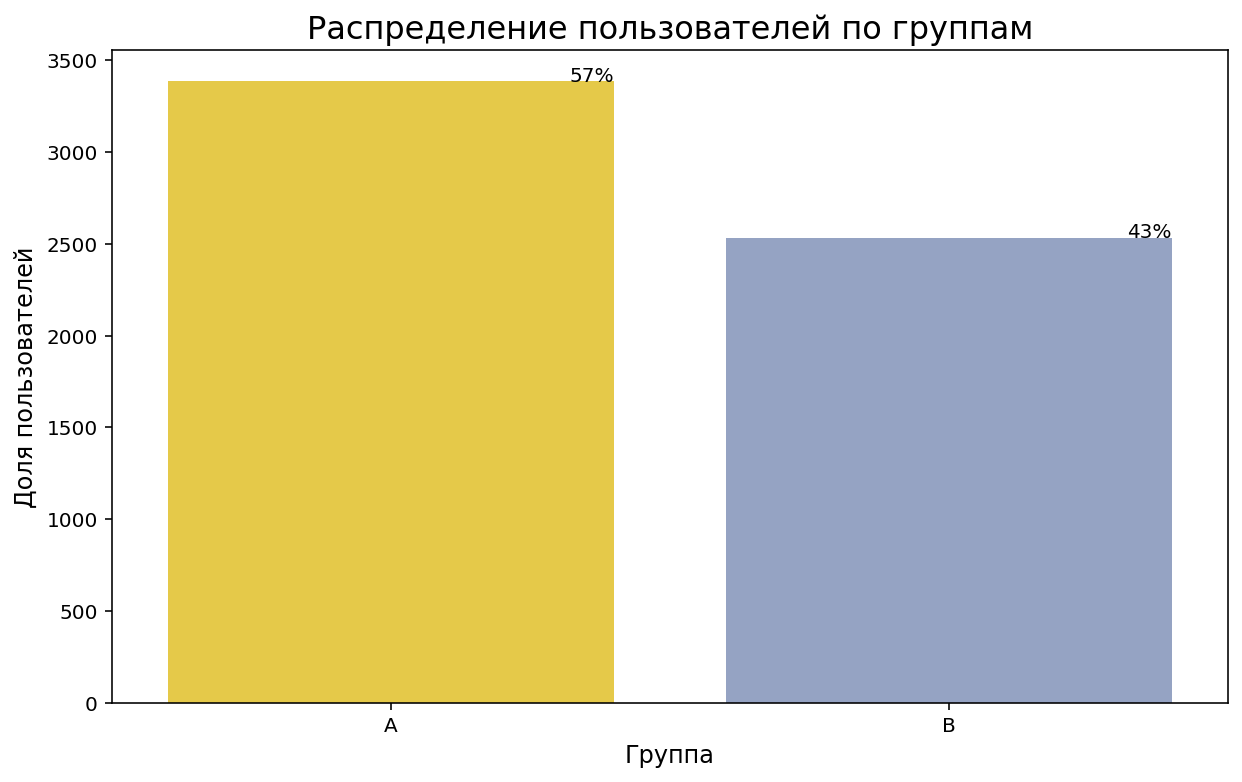

In [24]:
# визуализация диаграммы распределения пользователей по группам
fig = plt.figure(figsize=(10,6))
ax = sns.countplot(data=recommender_system_test_filtered,\
                  x='group', palette='Set2_r')
plt.title('Распределение пользователей по группам', fontsize=16)
plt.xlabel('Группа', fontsize=12)
plt.ylabel('Доля пользователей', fontsize=12)

for p in ax.patches:
    percentage = '{:.0f}%'.format(100 * p.get_height()\
                                  / recommender_system_test_filtered['user_id']\
                                  .count())
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='right')

plt.show()

Количество пользователей в двух группах распределено неравномерно – контрольная выборка 57%, а тестовая – всего 43%. 

Учтем это при анализе.

### Создание датасетов с данными теста

Объединим датасеты тестовой выборки и данных о пользователях:


In [25]:
df_participants = users.merge(recommender_system_test_filtered, how='inner', on='user_id')

Получился датасет с данными пользователей в тестовой выборке на 5918 записей.

Создадим сырой датасет, добавив данные по событиям:

In [26]:
df_raw = events.merge(df_participants, how='right', on='user_id')
df_raw.shape

(24516, 9)

По условиям ТЗ, в выборку должны входить новые пользователи за 14 дней с момента регистрации.

Отфильтруем датасет по этому признаку, удалив пользователей, которые пришли более чем через 14 дней после начала теста:

In [27]:
# создадим копию датафрейма с очищенными данными
df_final = df_raw.copy()
df_final['delta'] = df_final['first_date'] + pd.Timedelta(days=14)

df_final = df_final.query('first_date <= delta')
df_final.drop(columns='delta', inplace=True)
df_final.shape

(24516, 9)

In [28]:
print('Количество уникальных пользователей:', df_final['user_id'].nunique())
print('Количество уникальных пользователей с событиями (активных):',\
      df_final.query('event_dt == event_dt')['user_id'].nunique())

Количество уникальных пользователей: 5918
Количество уникальных пользователей с событиями (активных): 3244


Получили финальный датасет для анализа на 21085 записей, где всего 3244 пользователя из выборки целевого теста совершали события.

Запомним это число, чтобы оценить соответствие теста ТЗ.

### Оценка корректности проведения теста


**Техническое задание**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

1. Название теста и контрольные группы **соответствуют** ТЗ.

2. Проверим временные диапазоны сбора данных в датасете с тестом:

In [29]:
# вывод диапазона дат
print('Дата начала набора новых пользователей: {} \nДата окончания набора новых пользователей: {}\n'\
      .format(df_final['first_date'].min(),\
              df_final['first_date'].max()))

# вывод длительности теста
print('Длительность набора новых пользователей: {} \n'\
      .format(df_final['first_date'].max() -\
              df_final['first_date'].min()))

Дата начала набора новых пользователей: 2020-12-07 00:00:00 
Дата окончания набора новых пользователей: 2020-12-21 00:00:00

Длительность набора новых пользователей: 14 days 00:00:00 



Даты старта и остановки набора новых пользователей **соответствуют** ТЗ.

In [30]:
# вывод даты остановки сбора данных
print('Дата последнего события в тесте: {}'\
      .format(df_final['event_dt'].max()))

Дата последнего события в тесте: 2020-12-30 12:42:57


По факту сбор данных завершился на несколько дней раньше, что **не соответствует** ТЗ.


3. По ТЗ аудитория теста должна составлять 15% новых пользователей из региона EU.

Посчитаем число пользователей регионов и выведем их доли:

In [31]:
# группировка пользователей теста по региону
region_ab_ratio = df_participants.groupby('region').agg({'user_id':'count'})\
                  .rename(columns={'user_id': 'total'})\
                  .sort_values(by='total', ascending=False).reset_index()

# добавим столбец с долей от всех пользователей группы
region_ab_ratio['ratio'] = (region_ab_ratio['total'] \
                         / users.query('region == "EU"')['user_id'].count())\
                          * 100

# сохранение выборки с пользователями теста из EU
eu_participants = df_participants.query('region == "EU"')

# вывод значений
region_ab_ratio.sort_values(by='total', ascending=False)

,region,total,ratio
0,EU,5568,12.03
1,N.America,223,0.48
2,APAC,72,0.16
3,CIS,55,0.12


Процент пользователей из региона `EU` **не соответствует** ТЗ и составляет всего 12% вместо необходимых 15%.

Количество пользователей из других регионов незначительное, можно не отфильтровывать.

4. По ТЗ ожидаемое количество участников теста должно быть 6000.

Выведем число пользователей теста по факту:

In [32]:
print('Ожидаемое число пользователей: {}'.format(6000))
print('Фактическое число пользователей: {}'.format(len(df_participants)))
print('Разница план/факт по пользователям: {}%'.format(round(len(df_participants) / 6000)))

Ожидаемое число пользователей: 6000
Фактическое число пользователей: 5918
Разница план/факт по пользователям: 1%


Число пользователей в тесте незначительно **не соответствует** ТЗ.

### Проверка пересечения с маркетингом

Время проведения теста не должно совпадать с маркетинговыми и другими активностями – иначе результаты теста нельзя считать достоверными, так как на конверсию могли повлиять внешние факторы.

Проверим, не пересекаются ли тесты с диапазоном проведения маркетинговых акций.

In [33]:
# добавление времени проведения теста в датасет маркетинговых мероприятий
test = {'name': 'recommender_system_test',\
        'regions': 'EU, CIS, APAC, N.America',\
        'start_dt': date_threshold_min,\
        'finish_dt': date_threshold_max}
marketing_test = marketing.append(test, ignore_index = True)

In [34]:
# визуализация диаграммы Ганта
fig = px.timeline(marketing_test.query('start_dt >= @date_threshold_min'),\
                  x_start='start_dt', x_end='finish_dt', y='name',\
                  color='regions', width=1200, height=450,\
                  title='Пересечение теста и маркетинговых мероприятий',\
                  labels={'name':'Название мероприятия', 'regions':'Регионы проведения'})

fig.show()

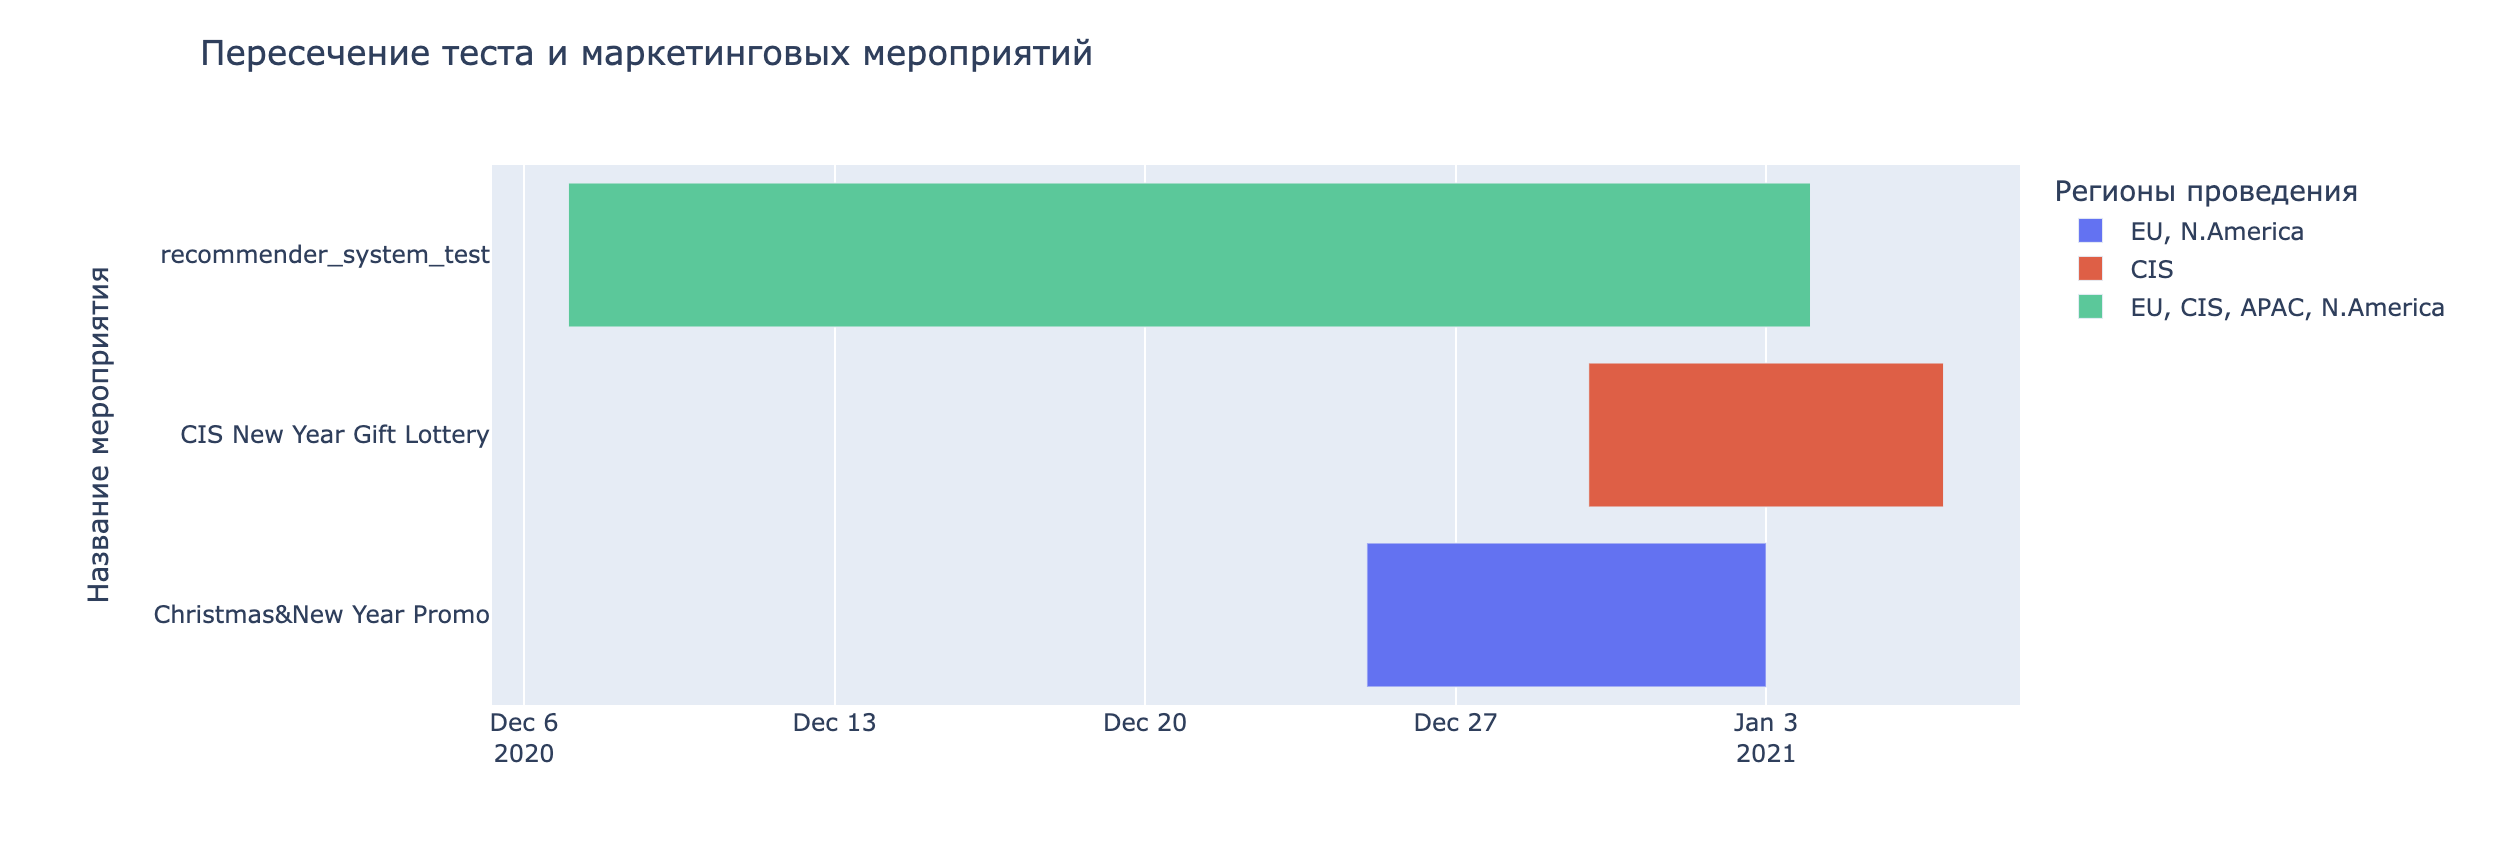

Найдена еще одна **ошибка в проведении теста**: время проведения пересекается с маркетинговыми мероприятиями в тех же регионах, что могло повлиять на изменение конверсии.

Даты начала промоакций, начиная с которых тест не валиден: 2020-12-25 для региона `EU` и `N.America` и 2020-12-30 для `CIS`.

### Вывод по шагу


Мы обработали недочеты и почистили данные, разделили датасет с тестами.

После разделения тестовых датасетов пересечения по `user_id` пропали – они были связаны со смешением пользователей в двух тестах.

Был создан общий датасет по тестовой выборке, включающий данные о пользователях и событиях. Он был проверен на соответствие техническому заданию. 

На этапе проверки соответствия ТЗ уже выявлены **ошибки проведения теста**:
* Наличие пересечений пользователей в двух тестах говорит о том, что параллельно было запущено 2 тестирования и часть пользователей попала под оба теста одновременно
* Число пользователей в тесте не соответствует ТЗ и составляет на 1% меньше запланированных 6000
* Количество пользователей в двух группах целевого теста распределено неравномерно – контрольная выборка составляет 57%, а тестовая – всего 43%
* Процент пользователей из региона `EU` не соответствует ТЗ и составляет всего 12% вместо необходимых 15%
* Время проведения пересекается с маркетинговыми мероприятиями в тех же регионах, что могло повлиять на изменение конверсии
* Всего 3244 пользователя из выборки целевого теста совершали события
* По факту сбор данных завершился раньше


Данные обработаны и подготовлены. Можно приступать к исследовательскому анализу.

## Исследовательский анализ данных (EDA)


Рассмотрим следующие вопросы:

- Количество событий на пользователя одинаково распределены в выборках?
- Как число событий в выборках распределено по дням?
- Как меняется конверсия в воронке в выборках на разных этапах?
- Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

Рассмотрим неактивных пользователей, прежде чем проводить анализ по пользователям с совершенными действиями:

In [35]:
# выделим пользователей без событий
df_na = df_raw.query('event_dt != event_dt')
print('Количество пользователей без событий:', df_na['event_dt'].isna().sum())

Количество пользователей без событий: 2674


In [36]:
# группировка по неактивным пользователям в тестовых группах
user_na_events = df_final.query('event_dt != event_dt') \
    .groupby(['group'], as_index=False) \
    .agg({'user_id' : 'nunique'}) \
    .rename(columns=({'event_name' : 'total_events'})) \
    .sort_values(by='group', ascending=True)

user_na_events 

,group,user_id
0,A,963
1,B,1711


In [37]:
# расчитаем доли неактивных пользователей по группам

na_ratio_b = df_final.query('event_dt != event_dt and group == "B"')['user_id'].nunique() \
                 / (df_final.query('group == "B"')['user_id'].nunique()) * 100
na_ratio_a = df_final.query('event_dt != event_dt and group == "A"')['user_id'].nunique() \
                 / (df_final.query('group == "A"')['user_id'].nunique()) * 100


print('Доля неактивных пользователей в группе A: {}%'.format(round(na_ratio_a)))
print('Доля неактивных пользователей в группе B: {}%'.format(round(na_ratio_b)))

Доля неактивных пользователей в группе A: 28%
Доля неактивных пользователей в группе B: 68%


Большая часть неактивных пользователей – из тестовой группы `B`.

Кроме того, доля неактивных пользователей в группе в несколько раз выше, чем в контрольной.

**Это может указывать на то, что новая версия рекомендательной системы на самом верхнем этапе воронки – вовлечение пользователя в пользование продуктом – работает хуже.**

Рассмотрим теперь пользователей с событиями.

### Распределение событий на пользователя в выборках

Сгруппируем данные по событиям пользователей теста и выведем основные статистики:

In [38]:
# группировка по пользователю и количеству событий
user_events = df_final.query('event_dt == event_dt') \
    .groupby(['user_id', 'group'], as_index=False) \
    .agg({'event_name' : 'count'}) \
    .rename(columns=({'event_name' : 'total_events'})) \
    .sort_values(by='group', ascending=True)

In [39]:
# выведем количество уникальных пользователей теста
total_users = df_final['user_id'].nunique()
print('Уникальных пользователей теста: {}'
      .format(total_users))

# выведем количество уникальных пользователей теста с событиями (активные)
active_users = df_final.query('event_dt == event_dt')['user_id'].nunique()
print('Активных пользователей теста: {}'
      .format(active_users))

# выведем долю активных пользователей теста
active_users_ratio = active_users / total_users * 100
print('Доля активных пользователей теста: {}% \n'
      .format(round(active_users_ratio)))


# расчеты для всей тестовой выборки
print('== По всем пользователям теста ==')
print('Минимальное число событий на пользователя: {} \
      \nМаксимальное число событий на пользователя: {}\n'\
      .format(int(user_events['total_events'].min()),
              int(user_events['total_events'].max())))

print('Среднее число событий на пользователя: {} \
      \nМедиана числа событий на пользователя: {} \
      \nМода числа событий на пользователя: {} \
      \n'\
      .format(int(user_events['total_events'].mean()),
              int(user_events['total_events'].median()),
              int(user_events['total_events'].mode())))


# расчеты для пользователей в группе B
print('== По пользователям в группе B ==')
user_events_b = user_events.query('group == "B"')

print('Минимальное число событий на пользователя: {} \
      \nМаксимальное число событий на пользователя: {}\n'\
      .format(int(user_events_b['total_events'].min()),
              int(user_events_b['total_events'].max())))

print('Среднее число событий на пользователя: {} \
      \nМедиана числа событий на пользователя: {} \
      \nМода числа событий на пользователя: {} \
      \n'\
      .format(int(user_events_b['total_events'].mean()),
              int(user_events_b['total_events'].median()),
              int(user_events_b['total_events'].mode())))

Уникальных пользователей теста: 5918
Активных пользователей теста: 3244
Доля активных пользователей теста: 55% 

== По всем пользователям теста ==
Минимальное число событий на пользователя: 1       
Максимальное число событий на пользователя: 28

Среднее число событий на пользователя: 6       
Медиана числа событий на пользователя: 6       
Мода числа событий на пользователя: 6       

== По пользователям в группе B ==
Минимальное число событий на пользователя: 1       
Максимальное число событий на пользователя: 28

Среднее число событий на пользователя: 5       
Медиана числа событий на пользователя: 5       
Мода числа событий на пользователя: 4       



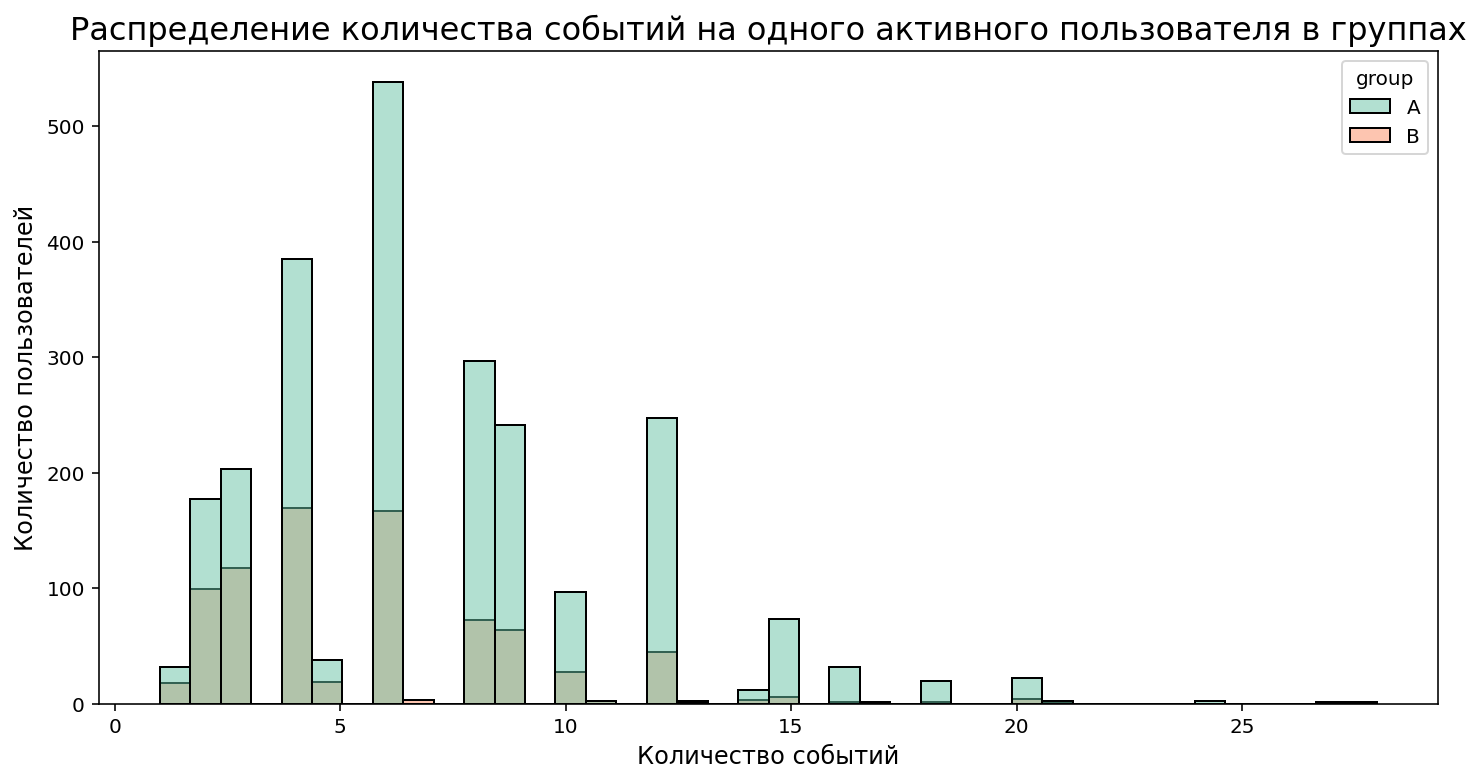

In [40]:
# визуализация гистограммы числа событий на одного пользователя
plt.figure(figsize=(12,6))
ax = sns.histplot(data=user_events, x='total_events',\
                  hue='group', palette='Set2')
plt.title('Распределение количества событий на одного активного пользователя в группах', fontsize=16)
plt.xlabel('Количество событий', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.show()

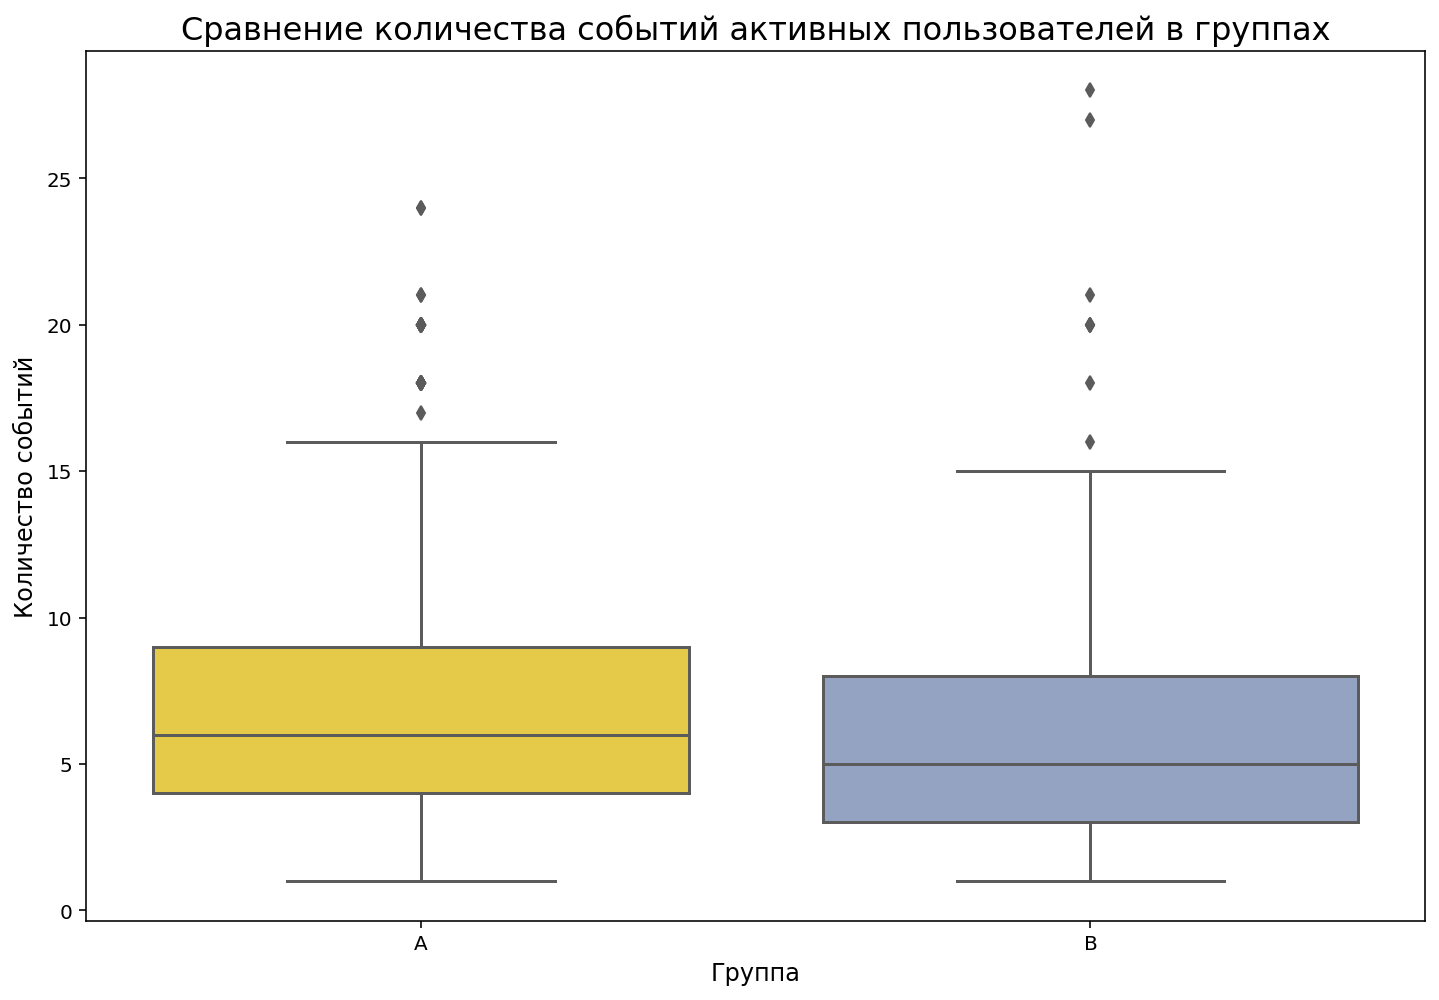

In [41]:
# визуализация диаграммы размаха числа событий по каждой группе
plt.figure(figsize=(12,8))
sns.boxplot(data=user_events, x='group', y='total_events', palette='Set2_r')
plt.title('Сравнение количества событий активных пользователей в группах', fontsize=16);
plt.xlabel('Группа', fontsize=12)
plt.ylabel('Количество событий', fontsize=12)
plt.show()

Распределение по обеим группам ожидаемо смещено вправо. 

Мода, медиана и среднее количество событий у пользователей группы `B` негативно отличаются от контрольной группы.

В группе `B` значительно больше событий вне основного диапазона – выбросов.



### Распределение событий по дням

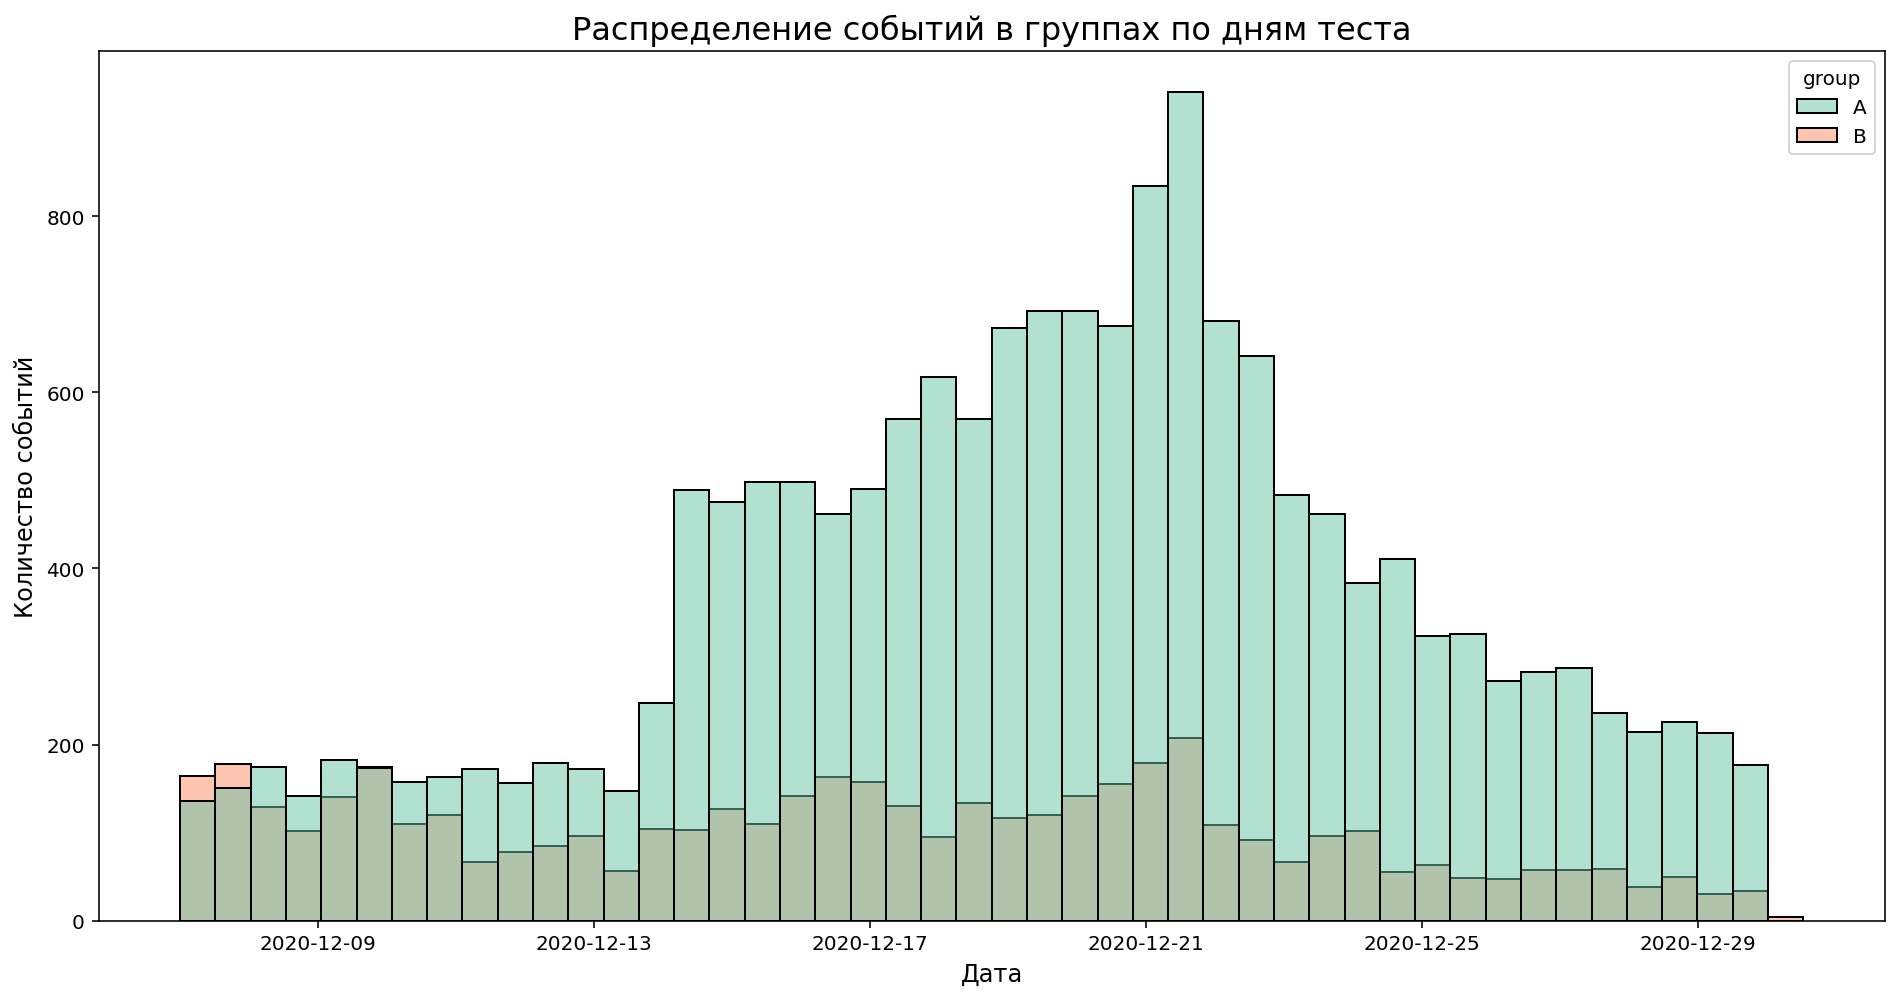

In [42]:
# визуализация гистограммы числа событий по дням и тестовым группам
plt.figure(figsize=(16,8))
ax = sns.histplot(data=df_final, x='event_dt',\
                  hue='group', palette='Set2')
plt.title('Распределение событий в группах по дням теста', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество событий', fontsize=12)
plt.show()

Интересно, что в первые 2 дня теста пользователи группы B совершили больше событий.

Спустя 1 неделю теста количество событий в группе `А` резко возрастает, тогда как в группе `B` остается почти на том же уровне. 

Маркетинговых мероприятий в это время по календарю не проводилось. Возможно, настройки теста были изменены случайно или специально, в выборочную совокупность стало поступать больше пользователей тестовой группы.

Выделяется рост трафика с 14.12.2020.

Соответственно, имеет место быть невалидность результатов теста на 3 и 4 неделях тестирования. Похоже, что корректные результаты теста можно увидеть только в первые несколько дней теста.


### Конверсия в воронке

Рассмотрим, как меняется конверсия воронки в выборках на разных этапах.

Посмотрим, какие события есть в логах, как часто они встречаются. 

Отсортируем события по частоте:

In [43]:
# группировка по событиям с сортировкой по частоте
events_count = df_final\
              .groupby(['event_name']) \
              .agg({'event_dt' : 'count'}) \
              .rename(columns=({'event_dt' : 'total_events'})) \
              .sort_values(by='total_events', ascending=False) \
              .reindex(['login', 'product_page', 'product_cart', 'purchase']) \
              .reset_index()
              
events_count

,event_name,total_events
0,login,9901
1,product_page,6116
2,product_cart,2886
3,purchase,2939


Видим, что число событий Покупка больше, чем число Просмотров корзины. 

Это не ошибка, если в нашей базе покупкой считается каждый отдельный продукт, а не вся корзина сразу. Значит, в части покупательских корзин было по несколько товаров (комбо?).

Посчитаем, сколько пользователей совершали каждое из этих событий. 

Отсортируем события по числу пользователей. 
Посчитаем долю пользователей, которые хоть раз совершали событие.

In [44]:
# сгруппируем данные по событиям и количеству пользователей с сортировкой
events_by_users = df_final \
    .groupby(['event_name']) \
    .agg({'user_id' : 'nunique'}) \
    .rename(columns=({'user_id' : 'total_users'})) \
    .sort_values(by='total_users', ascending=False) \
    .reindex(['login', 'product_page', 'product_cart', 'purchase']) \
    .reset_index()

# добавим столбцы с процентными соотношениями шагов воронки
events_by_users['percent_initial'] = events_by_users['total_users'] \
    .apply(lambda x: (x/events_by_users['total_users'][0]*100))

events_by_users['percent_previous'] = (events_by_users['total_users'] \
                                            / events_by_users['total_users'].shift() * 100)
events_by_users['percent_previous'][0]=100
events_by_users['percent_previous']=events_by_users['percent_previous']

events_by_users['percent_total'] = events_by_users['total_users'] \
    .apply(lambda x: (x/total_users*100))

events_by_users

,event_name,total_users,percent_initial,percent_previous,percent_total
0,login,3244,100.00,100.00,54.82
1,product_page,2030,62.58,62.58,34.30
2,product_cart,953,29.38,46.95,16.10
3,purchase,999,30.80,104.83,16.88


Изучим воронки событий в разрезе групп:

In [45]:
# группировка по событиям и группам
df_events = df_final \
    .groupby(['event_name', 'group']) \
    .agg({'user_id' : 'nunique'}) \
    .rename(columns=({'user_id' : 'total_users'})) \
    .sort_values(by='total_users', ascending=False) \
    .reset_index()

# фильтр по группам и сортировка событий
events_A = df_events.query('group == "A"').reindex([0,1,4,3])
events_B = df_events.query('group == "B"').reindex([2,5,7,6])

In [46]:
# визуализация воронки событий по группам
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, subplot_titles=("Group A","Group B"))

fig.add_trace(go.Funnel(
    x=events_A['total_users'],
    y=events_A['event_name'],
    textinfo = 'value+percent previous+percent total',
    textposition = 'inside',
    marker = {'color': 'lightblue'}),
    row=1, col=1)


fig.add_trace(go.Funnel(
    orientation = "h",
    x=events_B['total_users'],
    y=events_B['event_name'],
    textinfo = 'value+percent previous+percent total',
    textposition = 'inside',
    marker = {'color': 'coral'}),
    row=1, col=2)

fig.update_layout(
    autosize=False,
    width=1200,
    height=450,
    title='Воронки событий теста по группам',
    showlegend=False)

fig.show()

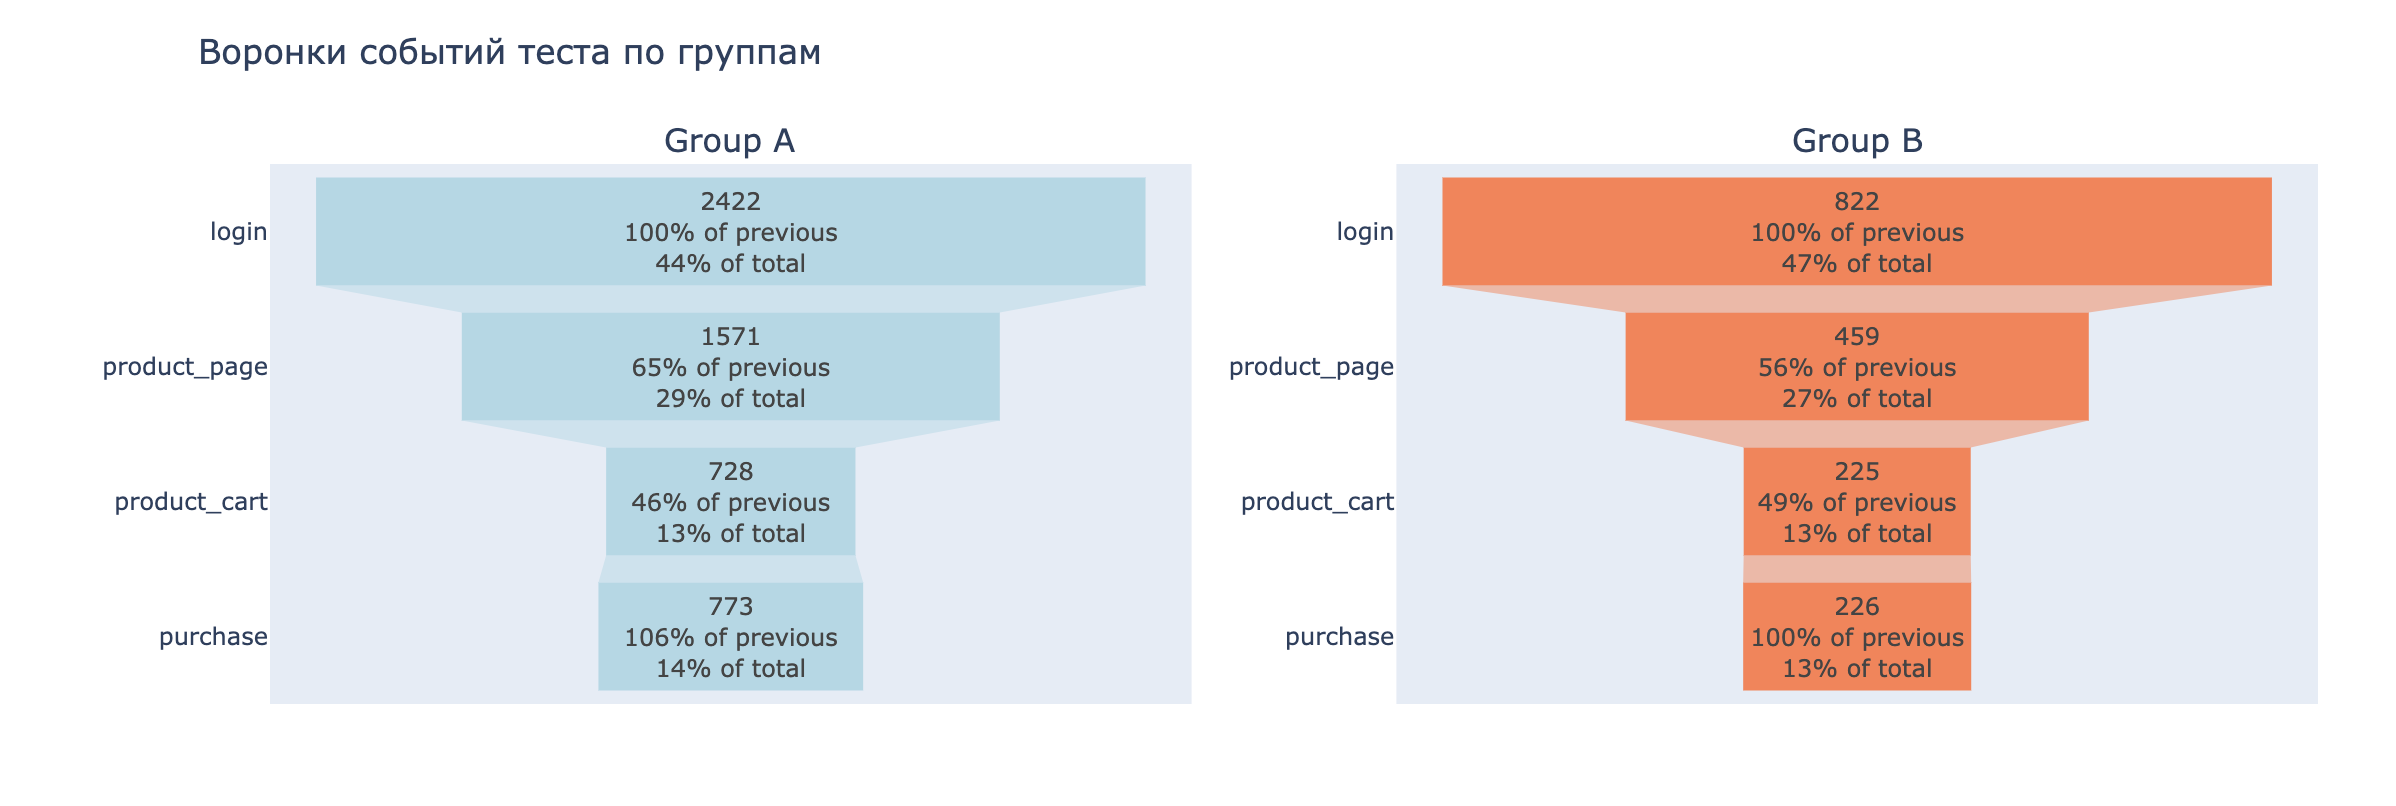

Что видим:
- конверсия в `login` в тестовой группе лучше контрольной
- конверсия в просмотр продуктов в тестовой группе снижается, вместо того, чтобы вырасти на 10% (как предполагалось по ТЗ)
- конверсия в корзину тоже не растет, одинакова в обеих группах
- конверсия в целевое действие Покупка в тестовой группе оказалась даже ниже, чем в контрольной

Если бы тест был проведен корректно, можно было бы сделать вывод, что улучшенная рекомендательная система не работает.

Но так как тест был проведен некорректно, то выводы о качестве изменений делать нельзя.

**Дополнение**: количество событий Покупка может быть больше, если:
* в системе считается Покупкой не корзина полностью, а каждый товар в ней отдельно. Таким образом, если в корзине несколько товаров, то и число покупок будет больше посещений корзины
* или если покупкой является товар по подписке, списывания могут происходить автоматически, без участия корзины

### Вывод по шагу

Доля активных пользователей теста: 55%. Доля неактивных пользователей в тестовой группе в несколько раз выше, чем в контрольной.

**Это может указывать на то, что новая версия рекомендательной системы на самом верхнем этапе воронки – вовлечение пользователя в пользование продуктом – работает хуже.**

В целом, тестирование было проведено некорректно, результаты не могут ответить на вопрос о качестве изменений рекомендалельной системы.



## Результаты A/B-тестирования

### Изучение результатов эксперимента

In [47]:
# группировка пользователей по тестовым группам
test_users = df_final.groupby('group')\
                    .agg({'user_id':'nunique'})\
                    .rename(columns=({'user_id' : 'group_users'}))

test_users

,group_users
group,
A,3385
B,2533


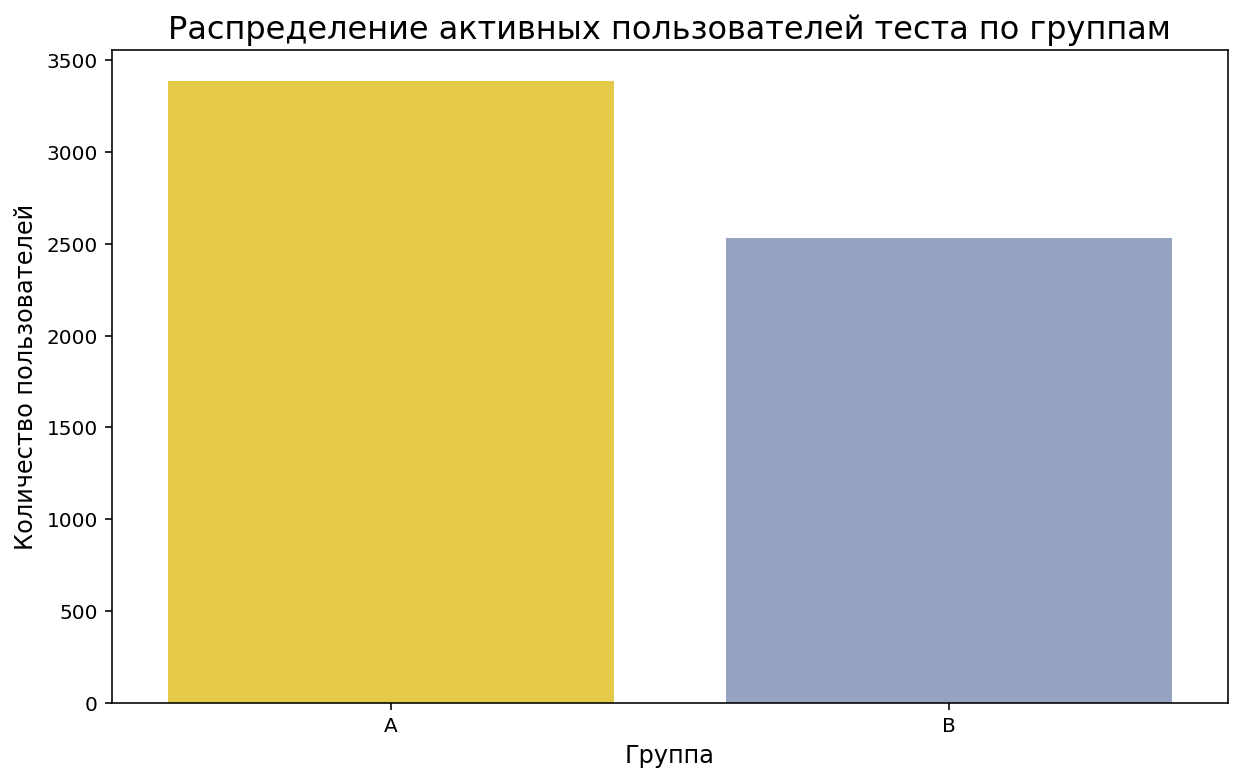

In [48]:
# визуализация диаграммы распределения пользователей по группам
fig = plt.figure(figsize=(10,6))
ax = sns.barplot(data=test_users,\
                  x=test_users.index, y='group_users', palette='Set2_r')
plt.title('Распределение активных пользователей теста по группам', fontsize=16)
plt.xlabel('Группа', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.show()

Мало того, что в выборке осталось очень мало активных пользователей, при этом распределение получилось неравномерное.

Посчитаем число пользователей, совершивших каждое из событий в каждой из контрольных групп. 

Добавим в таблицу долю пользователей, совершивших это событие в данной группе:

In [49]:
# объединим датасеты, добавив столбец с общим количеством в группе
test_events = df_events.merge(test_users, how='inner', on='group').rename(columns={'user_id' : 'group_users'})

# добавим столбец с долей от всех пользователей группы
test_events['percent_of_group'] = (test_events['total_users'] / test_events['group_users']*100)

# удалим столбец, он больше не нужен   
test_events = test_events.drop(['group_users'], axis=1)
test_events

,event_name,group,total_users,percent_of_group
0,login,A,2422,71.55
1,product_page,A,1571,46.41
2,purchase,A,773,22.84
3,product_cart,A,728,21.51
4,login,B,822,32.45
5,product_page,B,459,18.12
6,purchase,B,226,8.92
7,product_cart,B,225,8.88


Проверим, будет ли отличие между группами по совершенным событиям статистически достоверным.

Обернем проверку в отдельную функцию: 

In [50]:
# создадим список событий
names = list(test_events['event_name'].unique())

# зададим функцию для проверки гипотезы для двух групп
def z_test(test_users, test_events, group_1, group_2):

    
    alpha = .05 # критический уровень статистической значимости

    for event in names:
        # рассчитываемое событие
        successes = np.array([int(test_events.query('group == @group_1 \
                              & event_name == @event')['total_users']), \
                              int(test_events.query('group == @group_2 \
                              & event_name == @event')['total_users'])])

        # все события
        trials = np.array([test_users.loc[group_1, 'group_users'],\
                           test_users.loc[group_2, 'group_users']])

        # пропорция успехов в первой группе
        p1 = successes[0]/trials[0]

        # пропорция успехов во второй группе
        p2 = successes[1]/trials[1]

        # пропорция успехов в комбинированном датасете
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

        # разница пропорций в датасетах
        difference = p1 - p2

        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) \
                                        * (1/trials[0] + 1/trials[1]))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)

        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print('\nГруппы: {} и {}\
        \np-значение: {}'.format(group_1, group_2, p_value.round(2)))

        if (p_value < alpha):
            print('Событие: {}\
            \nОтвергаем нулевую гипотезу. \n---'\
                  .format(event))
        else:
            print('Событие: {} \
            \nНе получилось отвергнуть нулевую гипотезу. \n---'\
                  .format(event))

Теперь сформулируем гипотезу и проверим контрольные группы.

### Проверка гипотезы о равенстве долей в контрольной и тестовой группах

**Гипотеза:** доли пользователей с событиями в контрольной и тестовой группах равны

- $H_0$: доли пользователей в группах A и B равны
- $H_1$: доли пользователей в группах A и B отличаются

In [51]:
# запускаем функцию для расчета
z_test(test_users, test_events, 'A', 'B')


Группы: A и B        
p-значение: 0.0
Событие: login            
Отвергаем нулевую гипотезу. 
---

Группы: A и B        
p-значение: 0.0
Событие: product_page            
Отвергаем нулевую гипотезу. 
---

Группы: A и B        
p-значение: 0.0
Событие: purchase            
Отвергаем нулевую гипотезу. 
---

Группы: A и B        
p-значение: 0.0
Событие: product_cart            
Отвергаем нулевую гипотезу. 
---


При расчете с критическим уровнем статистической значимости в 5% у контрольных групп `A` и `B` гипотеза для каждого шага событий не подтвердилась, доли групп разные.

### Вывод по шагу


Результаты эксперимента для контрольных и тестовой групп по целевым действиям не имеют статистической значимости. 

## Общее заключение


**В исследовании были выявлены ошибки проведения теста**:
* Было выявлено, что параллельно было запущено 2 разных теста. Наличие пересечений пользователей в двух тестах говорит о том, часть пользователей попала под оба теста одновременно. Их пришлось удалить из выборки
* Общее число пользователей в тесте не соответствует ТЗ и составило на 1% меньше запланированных 6000. При этом всего 3244 пользователя из выборки целевого теста совершали события
* Доля активных пользователей теста: 55%. Количество активных пользователей в двух группах целевого теста распределено неравномерно, контрольная группа значительно больше тестовой. Вероятно, был сбой в настройках теста, вызвавший расширение контрольной выборки
* Процент пользователей из региона `EU` не соответствует ТЗ и составляет всего 12% вместо необходимых 15%
* Время проведения пересекается с маркетинговыми мероприятиями в тех же регионах, что повлияло на количество событий у пользователей, которые участвовали в акциях
* По факту сбор данных завершился раньше, чем запланировано по ТЗ

**Обнаруженные инсайты:**
Доля неактивных пользователей в тестовой группе в несколько раз выше, чем в контрольной – целых 68% пользователей вообще не совершили никаких действий (в контрольной группе – лишь 28%). Это может указывать на то, что новая версия рекомендательной системы на самом верхнем этапе воронки – вовлечение пользователя в пользование продуктом – работает хуже.


**Тест следует признать статистически незначимым, сделать достоверные выводы о качестве изменения продукта нельзя.**



**Рекомендации по коррекции теста для повторного проведения:**

* Запуск теста возможен только в даты, не пересекающиеся с периодом проведения маркетинговых акций или других тестов. По маркетинговым акциям возможен вариант, когда обе тестовые группы участвовуют в акциях, чтобы изменения конверсии можно было посчитать значимыми для обеих групп
* Общее число пользователей в тесте *очистки данных должно* соответствовать ТЗ – для этого рекомендуется либбо увеличить длительность проведения теста, либо включать увеличить объем выборочной совокупности. Это также повлияет на рекомендуемый процент пользователей по нужному региону
* Контролировать успешность проведения теста в период его проведения, отслеживая количество активных пользователей до набора рекомендуемого по ТЗ (6000)
* Следить за наполнением выборки, чтобы распределение тестовой и контрольной группы приближалось к равномерному. Идеальное распределение: 50/50
* Не завершать тест до накопления достаточного количества данных. Прерывание допустимо, если дата завершения пересекается с началом других активностей (маркетинговых, тестовых)
* Не допускается изменение настроек теста во время его проведения